In [ ]:
import pandas as pd
import json
import random
from collections import defaultdict
import os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE


In [2]:
res_list_1 = ["A_128_HIS", "A_129_ASP", "B_29_ALA"]
res_list_2 = ["A_128_HIS", "B_29_ALA", "B_44_CYS"]
inter = len(set.intersection(set(res_list_1), set(res_list_2)))
union = len(set.union(set(res_list_1), set(res_list_2)))

In [3]:
inter = len(np.intersect1d(res_list_1, res_list_2))
union = len(np.union1d(res_list_1, res_list_2))

In [4]:
inter

2

In [5]:
union

4

In [6]:
 (len(res_list_1) * len(res_list_2))

9

In [7]:
sim = 2 * inter / (len(res_list_1) * len(res_list_2))
# # norm by max
# sim = inter / max(len(res_list_1), len(res_list_2))
# # norm by min
# sim = inter / min(len(res_list_1), len(res_list_2))
# # norm by union
# sim = inter / union
# # distance can be calculated as inverse
dist = 1 - sim

In [8]:
sim

0.4444444444444444

In [9]:
dist

0.5555555555555556

In [10]:
file_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/BindingSiteAnalysis/kras_md_sites_1/0.pkl'  # Replace with the actual path to your .pkl file

with open(file_path, 'rb') as file:
    data = pickle.load(file)

In [11]:
data

{'target': {'chain_ids': chararray(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype='<U1'),
  'atom_names': array(['N', 'CA', 'C', ..., 'CE', 'NZ', 'C'], dtype='<U4'),
  'res_ids': array([  1,   1,   1, ..., 170, 170, 170], dtype=int32),
  'res_names': array(['GLY', 'GLY', 'GLY', ..., 'LYS', 'LYS', 'LYS'], dtype='<U3'),
  'coords': array([[68.072, 43.159, -9.384],
         [67.502, 43.042, -8.06 ],
         [66.156, 43.725, -8.038],
         ...,
         [52.697, 61.358,  7.875],
         [52.674, 60.525,  8.982],
         [55.934, 63.99 ,  4.519]], dtype=float32),
  'elements': array(['N', 'C', 'C', ..., 'C', 'N', 'C'], dtype='<U4')},
 'sites': [{'residues': ['A_14_GLY',
    'A_15_VAL',
    'A_16_GLY',
    'A_17_LYS',
    'A_19_ALA',
    'A_29_PHE',
    'A_117_ASN',
    'A_118_LYS',
    'A_147_ALA',
    'A_18_SER',
    'A_120_ASP',
    'A_148_LYS',
    'A_12_ALA',
    'A_13_CYS',
    'A_58_ASP'],
   'hotspots': [{'center': array([44.392616, 32.449608, 13.74522 ], dtype=float32),
     'scor

In [12]:
target_info = data.get('target', {})
sites_info = data.get('sites', [])

In [14]:
target_info

{'chain_ids': chararray(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype='<U1'),
 'atom_names': array(['N', 'CA', 'C', ..., 'CE', 'NZ', 'C'], dtype='<U4'),
 'res_ids': array([  1,   1,   1, ..., 170, 170, 170], dtype=int32),
 'res_names': array(['GLY', 'GLY', 'GLY', ..., 'LYS', 'LYS', 'LYS'], dtype='<U3'),
 'coords': array([[68.072, 43.159, -9.384],
        [67.502, 43.042, -8.06 ],
        [66.156, 43.725, -8.038],
        ...,
        [52.697, 61.358,  7.875],
        [52.674, 60.525,  8.982],
        [55.934, 63.99 ,  4.519]], dtype=float32),
 'elements': array(['N', 'C', 'C', ..., 'C', 'N', 'C'], dtype='<U4')}

In [15]:
len(target_info)

6

In [13]:
sites_info

[{'residues': ['A_14_GLY',
   'A_15_VAL',
   'A_16_GLY',
   'A_17_LYS',
   'A_19_ALA',
   'A_29_PHE',
   'A_117_ASN',
   'A_118_LYS',
   'A_147_ALA',
   'A_18_SER',
   'A_120_ASP',
   'A_148_LYS',
   'A_12_ALA',
   'A_13_CYS',
   'A_58_ASP'],
  'hotspots': [{'center': array([44.392616, 32.449608, 13.74522 ], dtype=float32),
    'scores': {'small_molecule': 0.99715304}},
   {'center': array([48.498127, 33.626034, 16.086721], dtype=float32),
    'scores': {'ion:-2': 0.59394413,
     'ion:SO4': 0.46435302,
     'ion:-3': 0.3886296,
     'ion:PO4': 0.3872312}},
   {'center': array([47.721817, 32.081375, 15.24441 ], dtype=float32),
    'scores': {'peptide': 0.3621357}},
   {'center': array([40.88744 , 32.174248, 11.77978 ], dtype=float32),
    'scores': {'peptide': 0.31265086}},
   {'center': array([51.676   , 34.33    , 22.048998], dtype=float32),
    'scores': {'covalent:residue-CYS': 0.23957469}},
   {'center': array([49.24807 , 33.785942, 15.513046], dtype=float32),
    'scores': {'ion:

In [16]:
len(sites_info)

2

In [22]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/BindingSiteAnalysis/kras_md_sites_1' 

file_names = []
target_counts = []
site_counts = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.pkl'):  # Process only .pkl files
        file_path = os.path.join(folder_path, file_name)
        
        try:
            # Load the .pkl file
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
            
            # Extract the number of targets and sites
            target_data = data.get('target', {})
            if isinstance(target_data, (dict, list)):  # Check if it's a collection
                target_count = len(target_data)
            else:
                target_count = 1 if target_data else 0  # Single target or none
                
            site_count = len(data.get('sites', [])) if 'sites' in data else 0
            
            # Append the data
            file_names.append(file_name)
            target_counts.append(target_count)
            site_counts.append(site_count)
        
        except Exception as e:
            # Handle any issues with loading or processing
            file_names.append(file_name)
            target_counts.append(None)
            site_counts.append(None)

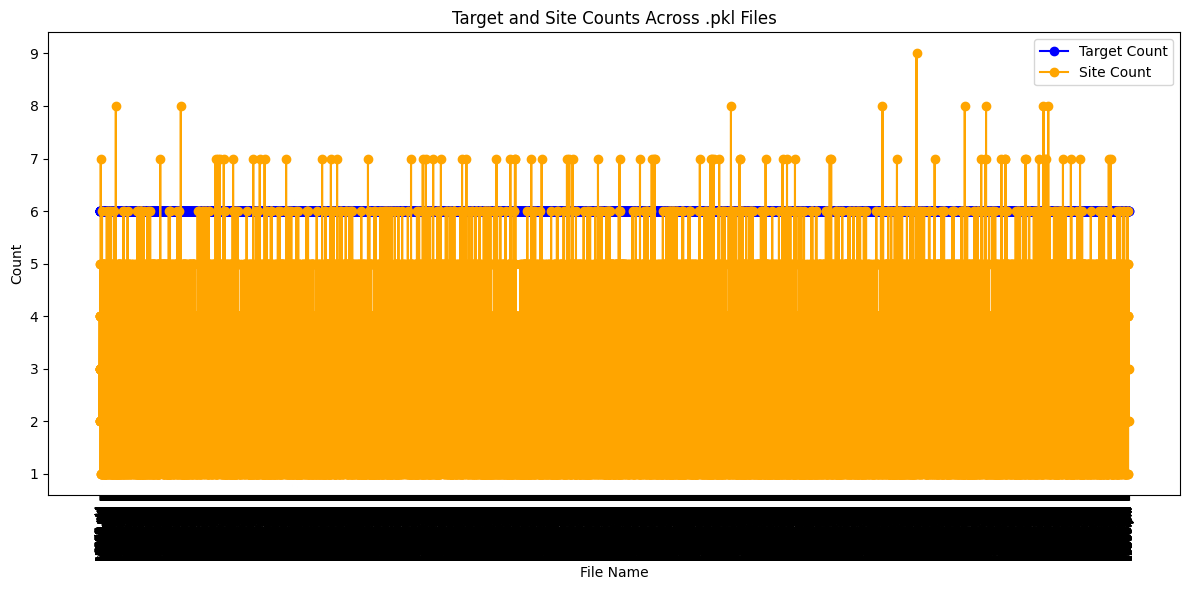

In [23]:
# Create a DataFrame for visualization
data_df = pd.DataFrame({
    'File': file_names,
    'Target Count': target_counts,
    'Site Count': site_counts
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_df['File'], data_df['Target Count'], marker='o', label='Target Count', color='blue')
plt.plot(data_df['File'], data_df['Site Count'], marker='o', label='Site Count', color='orange')
plt.xticks(rotation=90, fontsize=8)
plt.title('Target and Site Counts Across .pkl Files')
plt.xlabel('File Name')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

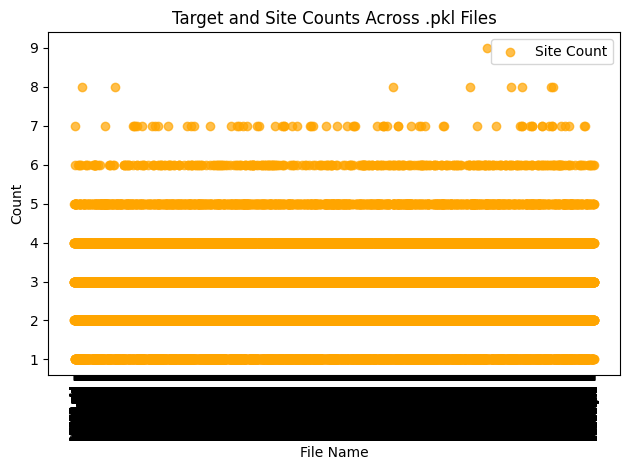

In [25]:
# Scatter plot for Site Count
plt.scatter(data_df['File'], data_df['Site Count'], label='Site Count', color='orange', alpha=0.7)

plt.xticks(rotation=90, fontsize=8)
plt.title('Target and Site Counts Across .pkl Files')
plt.xlabel('File Name')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Distance/Similarity calculation and clustering

In [33]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/BindingSiteAnalysis/kras_md_sites_1'  # Replace with your actual folder path


In [34]:
# Initialize a list to store binding site data
all_binding_sites = []

# Loop through all files in the folder
for file_name in sorted(os.listdir(folder_path)):  # Ensure consistent order
    if file_name.endswith('.pkl'):  # Process only .pkl files
        file_path = os.path.join(folder_path, file_name)
        
        try:
            # Load the .pkl file
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
            
            # Extract binding site information
            sites = data.get('sites', [])
            for site in sites:
                all_binding_sites.append(site)
        
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

print(f"Total binding sites extracted: {len(all_binding_sites)}")

Total binding sites extracted: 60791


In [40]:
def residue_overlap_distance(site1, site2):
    # Assuming each site has a 'residues' list
    residues1 = set(site1.get('residues', []))
    residues2 = set(site2.get('residues', []))
    
    if not residues1 or not residues2:  # Handle empty residue lists
        return 1.0  # Maximum distance if one of the sites has no residues
    
    # Jaccard distance = 1 - Jaccard similarity
    return 1 - len(residues1 & residues2) / len(residues1 | residues2)

In [41]:
def pairwise_distances_with_library(sites, distance_func):
    # Custom metric for pdist
    def distance_wrapper(i, j):
        return distance_func(sites[int(i[0])], sites[int(j[0])])
    
    # pdist expects a 2D array; use indices as placeholders
    indices = list(range(len(sites)))
    condensed_matrix = pdist([[i] for i in indices], metric=lambda i, j: distance_wrapper(i, j))
    
    # Convert to squareform distance matrix
    return squareform(condensed_matrix)


In [42]:
subset = all_binding_sites[:100]  # First 100 sites
distance_matrix = pairwise_distances_with_library(subset, residue_overlap_distance)

In [ ]:
# # Create a pairwise distance matrix
# num_sites = len(all_binding_sites)
# distance_matrix = np.zeros((num_sites, num_sites))

# for i in range(num_sites):
#     for j in range(i + 1, num_sites):  # Only calculate upper triangle (matrix is symmetric)
#         distance_matrix[i, j] = residue_overlap_distance(all_binding_sites[i], all_binding_sites[j])
#         distance_matrix[j, i] = distance_matrix[i, j]  # Mirror to lower triangle

# print("Distance matrix created.")

KeyboardInterrupt: 

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


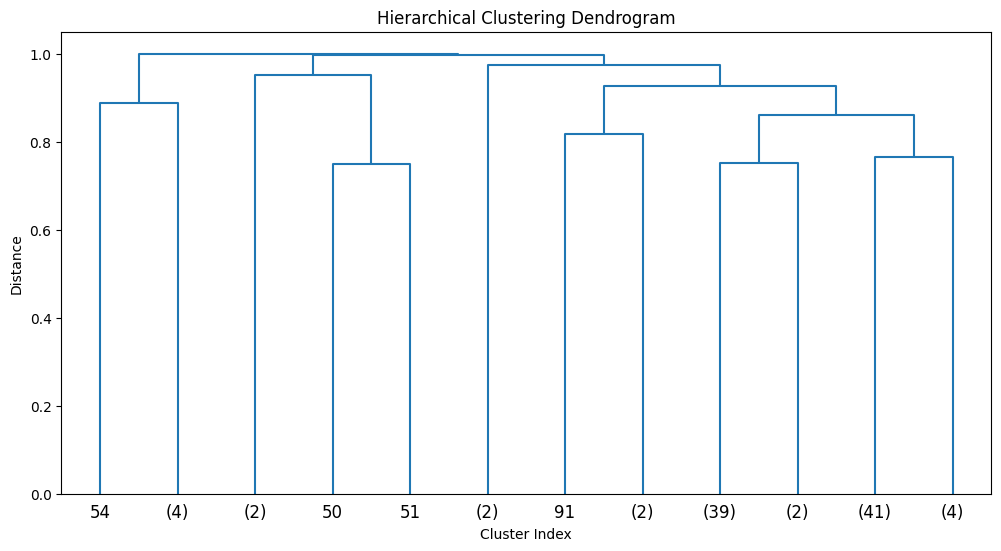

Number of clusters formed: 19


In [44]:
# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Visualize dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

# Extract clusters (e.g., cluster binding sites with distance < 0.5)
clusters = fcluster(linkage_matrix, t=0.5, criterion='distance')
print(f"Number of clusters formed: {len(set(clusters))}")

In [45]:
from sklearn.cluster import DBSCAN

In [46]:
# Perform DBSCAN clustering
dbscan = DBSCAN(metric='precomputed', eps=0.5, min_samples=2)
labels = dbscan.fit_predict(distance_matrix)

# Analyze clusters
unique_labels = set(labels)
print(f"Number of clusters (excluding noise): {len(unique_labels) - (1 if -1 in unique_labels else 0)}")
print(f"Noise points: {list(labels).count(-1)}")

Number of clusters (excluding noise): 5
Noise points: 6


In [50]:
# Map clusters to binding sites
site_clusters = pd.DataFrame({
    'Site': subset,
    'Cluster': clusters  # Replace with `labels` for DBSCAN
})

# Save to CSV for further analysis
site_clusters.to_csv('binding_site_clusters.csv', index=False)
print("Cluster assignments saved to binding_site_clusters.csv")

Cluster assignments saved to binding_site_clusters.csv


In [48]:
from sklearn.manifold import TSNE


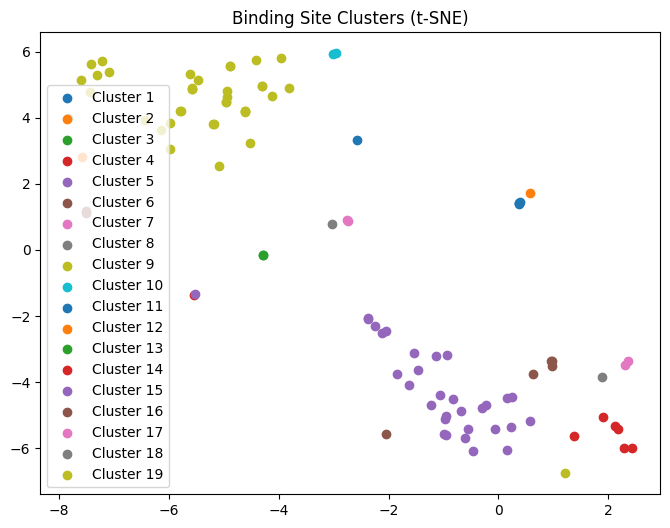

In [51]:
# Reduce dimensionality
# embedding = TSNE(n_components=2, metric='precomputed').fit_transform(distance_matrix)
embedding = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix)

# Scatter plot
plt.figure(figsize=(8, 6))
for cluster in set(clusters):
    cluster_points = embedding[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.title('Binding Site Clusters (t-SNE)')
plt.legend()
plt.show()

#### Clustering based on residue scores


In [58]:
def residue_score_distance(site1, site2):
    scores1 = site1.get('residue_scores', {})
    scores2 = site2.get('residue_scores', {})
    
    common_residues = set(scores1.keys()) & set(scores2.keys())
    if not common_residues:
        return 10.0 
    
    # Compute mean absolute difference of scores for overlapping residues
    return sum(abs(scores1[res] - scores2[res]) for res in common_residues) / len(common_residues)

In [59]:
distance_matrix_scores = pairwise_distances_with_library(subset, residue_score_distance)

In [60]:
# Verify that all distances are finite
if not np.all(np.isfinite(distance_matrix_scores)):
    print("Non-finite values found in distance matrix!")

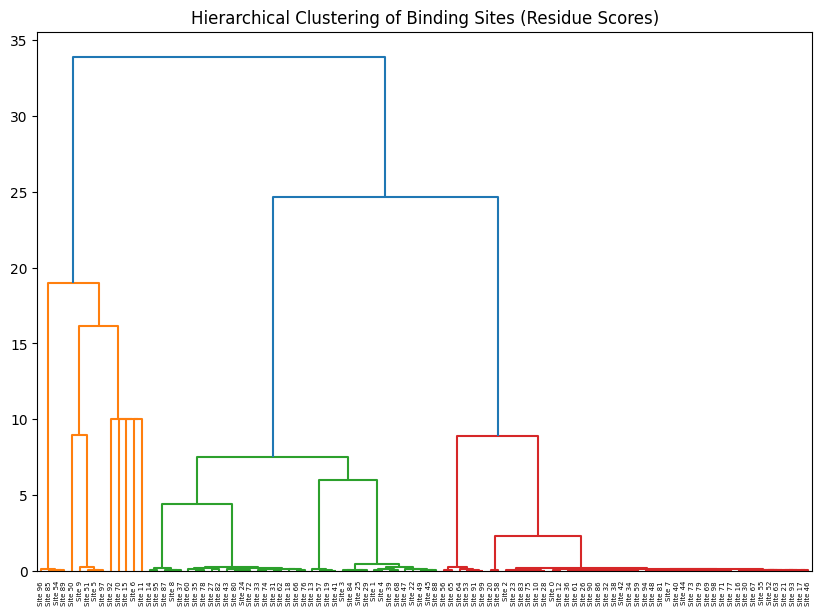

In [61]:
# Linkage matrix for hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix_scores), method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[f"Site {i}" for i in range(len(subset))])
plt.title("Hierarchical Clustering of Binding Sites (Residue Scores)")
plt.show()

In [62]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative clustering
n_clusters = 5
clustering = AgglomerativeClustering(
    n_clusters=n_clusters, affinity='precomputed', linkage='average'
).fit(distance_matrix_scores)

# Labels
cluster_labels = clustering.labels_
print("Cluster labels:", cluster_labels)

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [63]:
# Perform Agglomerative Clustering
n_clusters = 5  # Choose the number of clusters
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',  # Replace 'affinity' with 'metric'
    linkage='average'
).fit(distance_matrix_scores)

# Cluster labels
cluster_labels = clustering.labels_
print("Cluster labels:", cluster_labels)

Cluster labels: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 3 1 1 1 2 1 1 1]


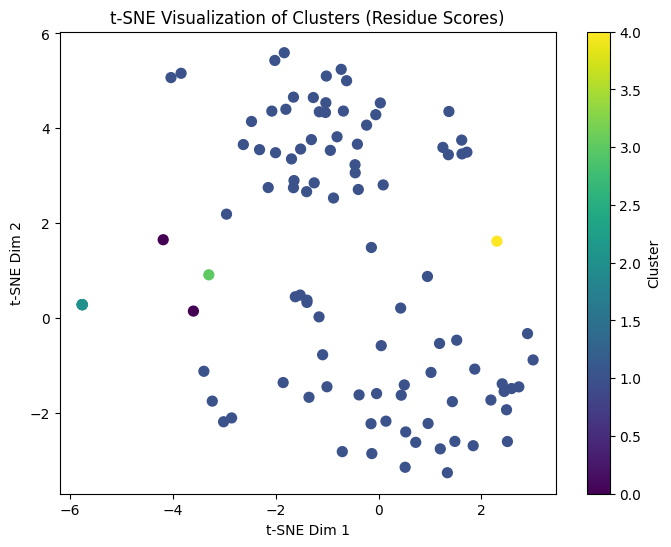

In [64]:
embedding_scores = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix_scores)

# Plot clusters
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding_scores[:, 0],
    embedding_scores[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=50
)
plt.colorbar(scatter, label='Cluster')
plt.title("t-SNE Visualization of Clusters (Residue Scores)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

#### Clustering based on hotspot coordinates
